<a href="https://colab.research.google.com/github/SahilNDev/NLP-Assignments/blob/main/NLP_Assignment_1_6074.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing all the packages and downloading requirements**

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import warnings
nltk.download('punkt')
warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Class with GridSearchCV and all the classifier models**

In [2]:
class Model:
  # constructor
  def __init__(self, X, y, splitPercent):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = splitPercent, random_state = 10, stratify = y)
    self.lr_best = self.logisticReg()
    self.svc_best = self.supportVC()
    self.rf_best = self.randomForest()

  # gridsearchcv
  def gridSearchCV(self, model, params):
    gscv = GridSearchCV(model, params, n_jobs = -1, cv = 5, scoring = "accuracy")
    gscv.fit(self.X_train, self.y_train)
    return gscv

  # logistic regression
  def logisticReg(self):
    lr = LogisticRegression()
    params = {'penalty': ['l2'], 'C': [0.001,0.01,0.1,1,10,100,1000], 'solver':['newton-cholesky', 'sag', 'saga', 'lbfgs']}
    lr_best = self.gridSearchCV(lr, params)
    return lr_best

  # support vector classifier
  def supportVC(self):
    svc = SVC()
    params = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf'], "max_iter" : [200]}
    svc_best = self.gridSearchCV(svc, params)
    return svc_best

  # random forest classifier
  def randomForest(self):
    rf = RandomForestClassifier()
    params = {
                'n_estimators': [200, 500],
                'max_features': ['sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8],
                'criterion' :['gini', 'entropy']
              }
    rf_best = self.gridSearchCV(rf, params)
    return rf_best

  # final reports with all the metrics of classification results
  def classificationReport(self):
    print("For Logistic Regression Classifier:")
    print("-"*25)
    print(classification_report(self.y_test, self.lr_best.predict(self.X_test)))
    print("For Support Vector Classifier:")
    print("-"*25)
    print(classification_report(self.y_test, self.svc_best.predict(self.X_test)))
    print("For Random Forest Classifier:")
    print("-"*25)
    print(classification_report(self.y_test, self.rf_best.predict(self.X_test)))

  # for individual prediction with a single example
  def predictResult(self, X):
    print("Prediction from Logistic Regression Classifier: ", self.lr_best.predict([X])[0])
    print("Prediction from Support Vector Classifier: ", self.svc_best.predict([X])[0])
    print("Prediction from Random Forest Classifier: ", self.rf_best.predict([X])[0])

## **Reading Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# reading data
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.shape

(50000, 2)

In [6]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [9]:
# removing null values
df.dropna(inplace = True)

In [10]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [11]:
df.shape

(50000, 2)

<Axes: >

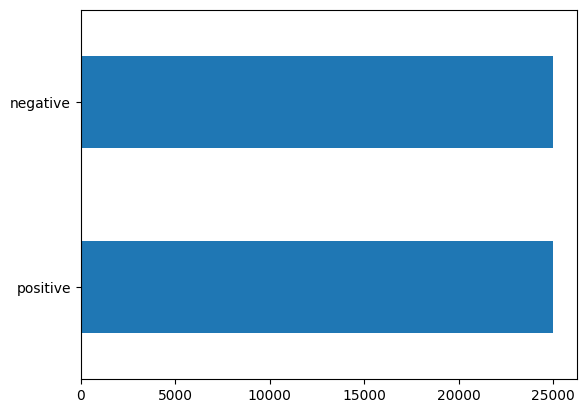

In [12]:
# visualizing balance of classes
df.sentiment.value_counts().plot(kind = "barh")

In [13]:
df.review.nunique()

49582

# **Goal: From "Title" predict "Label" i.e 0-Fake, 1-Real**

## Cleaning and Preprocessing

In [14]:
# lowering all the text along with stripping spaces from beginning and end of sentences
df.review = df.review.apply(lambda x: x.lower().strip())

In [15]:
# remove duplicates/ for every duplicate we will keep only one row of that type.
df.drop_duplicates(keep='first',inplace=True)

In [16]:
# removing digits
df.review = df.review.apply(lambda x: re.sub(r"\d+\w*", "", x))

In [17]:
# function for removing punctuations, stowords and lemamtizing the words
lemmatizer = WordNetLemmatizer()
def rem_punc_stopwords(text):
  # removes punctuations
  nonpunc = [char for char in text if char not in string.punctuation]
  nonpunc_text = "".join(nonpunc)
  # removing stopwords and lemmatizing
  nonsw = [lemmatizer.lemmatize(word) for word in nonpunc_text.split() if word not in stopwords.words('english')]
  return " ".join(nonsw)

In [18]:
# cleaning the remaining punctuations and filler words
df.review = df.review.apply(lambda x: re.sub(r"\[\w*\]", "", x))
# removing hashtags
df.review = df.review.apply(lambda x: re.sub(r"\w*#\w+", "", x))

In [ ]:
# removing punctuations, stowords and lemamtizing the words
df.review = df.review.apply(lambda x: rem_punc_stopwords(x))

In [ ]:
# cleaning the remaining punctuations and filler words
df.review = df.review.apply(lambda x: re.sub(r"’|“|”|…|‘|€|–", "", x))

In [ ]:
# removing filler words
df.review = df.review.apply(lambda x: re.sub("huh", "", x))

# function to remove one character word
def remove_one_char_word(text):
  return " ".join(word for word in text.split() if len(word)>1)

df.review = df.review.apply(lambda x: remove_one_char_word(x))

# **Vectorization**

In [ ]:
# for experiment
df_new = df.iloc[:50]

In [ ]:
# splitting in X and y
X = df.review
y = df.sentiment

## **CountVectorizer**

In [ ]:
# count vectorizer in action
cv = CountVectorizer()
X_mat = cv.fit_transform(X)

In [ ]:
# Doing splitting outside the class to test for any error
X_train, X_test, y_train, y_test = train_test_split(X_mat.toarray(), y, test_size = 0.3, random_state = 10, stratify = y)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
classification_report(lr.predict(X_test), y_test)

In [ ]:
# final classification
# classifier = Model(X_mat.toarray(), y, 0.3)
# classifier.classificationReport()

# **TfidfVectorizer**

In [ ]:
# term frequency inverse document frequency in action
tfidf = TfidfVectorizer()
X_mat_tfidf = tfidf.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_mat_tfidf.toarray(), y, test_size = 0.3, random_state = 10, stratify = y)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

In [ ]:
# final classification
# classifier = Model(X_mat_tfidf.toarray(), y, 0.3)
# classifier.classificationReport()

# **Word2Vec**

In [ ]:
# tokenizing each sentences
X_tokens = X.apply(lambda x: nltk.tokenize.word_tokenize(x))

In [ ]:
# fitting the data to the models for embeddings
model = Word2Vec(X_tokens, window=5, min_count=2, workers=4)

In [ ]:
# model.train(X_tokens, epochs = 10, total_examples = len(X_tokens))

In [ ]:
# saving the embeddings
# model.save("word2vec.model")

In [ ]:
# function to extract embeddings of each sentence
def get_embedding(text, model):
    embeddings = []
    for word in text:
        if word in model.wv:
            embeddings.append(model.wv[word])
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
# final emebddings of each sentence
X_final = X_tokens.apply(lambda x: get_embedding(x, model))

In [ ]:
# CLassificaiton with logistic regression
X_train, X_test, y_train, y_test = train_test_split(X_final.tolist(), y, test_size = 0.3, random_state =0, stratify = y)
lr_wv = LogisticRegression()
lr_wv.fit(X_train, y_train)
print(classification_report(y_test, lr_wv.predict(X_test)))

In [ ]:
# classificaiton with support vector classifier
svc_wv = SVC()
svc_wv.fit(X_train, y_train)
print(classification_report(y_test, svc_wv.predict(X_test)))

In [ ]:
# classification with random forest classifier
rf_wv = RandomForestClassifier()
rf_wv.fit(X_train, y_train)
print(classification_report(y_test, rf_wv.predict(X_test)))

In [ ]:
# final classification
# classifier = Model(X_final.tolist(), y, 0.3)
# classifier.classificationReport()

# **Google News Word2Vec**

In [ ]:
# importing library to downlado pretrained model
import gensim.downloader

In [ ]:
list(gensim.downloader.info()['models'].keys())

In [ ]:
# Downlaoding the model needed
word2vec = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
# training for our data
word2vec.train(X_tokens, epochs = 10, total_examples = len(X_tokens))

In [ ]:
# Generating embeddings
X_embeddings = X_tokens.apply(lambda x: get_embedding(x, word2vec))
X_ready = X_embeddings.tolist()

In [ ]:
# Logistic Regression Classification
X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size = 0.3, random_state =0, stratify = y)
lr_wv = LogisticRegression()
lr_wv.fit(X_train, y_train)
print(classification_report(y_test, lr_wv.predict(X_test)))

In [ ]:
# Support Vecto Classifier Classification
svc_wv = SVC()
svc_wv.fit(X_train, y_train)
print(classification_report(y_test, svc_wv.predict(X_test)))

In [ ]:
# Random Forest Classifier Classsification
rf_wv = RandomForestClassifier()
rf_wv.fit(X_train, y_train)
print(classification_report(y_test, rf_wv.predict(X_test)))

In [ ]:
# Final Classsification
classifier = Model(X_ready, y, 0.3)
classifier.classificationReport()